## towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial

In [17]:
import torch
import numpy as np
import torchvision

In [18]:
# Linear regresssion using mini-batch
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)
# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)
# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]
# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

# Initialize variable randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)
print(a, b)

lr = 1e-1
num_epochs = 1000

for epoch in range(num_epochs):
    # 1. Compute prediction
    y_hat = b * x_train + a
    
    # 2. Compute loss (MSE)
    error = (y_train - y_hat)  # use np.abs() why incorrect?
    loss = (error ** 2).mean()
    
    # 3. Compute gradient
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # 4. Update parameters
    a -= lr * a_grad
    b -= lr * b_grad

print(a, b)

from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


In [19]:
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


In [20]:
# Think: What distinguishes a tensor used for data from a tensor 
# used as a (trainable) parameter/weight?

# Note that .to(device) shadow the gradient
# a = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
# b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)

# Instead, to create GPU tensors, using the order below
a = torch.randn(1, dtype=torch.float).to(device)
b = torch.randn(1, dtype=torch.float).to(device)
a.requires_grad_()
b.requires_grad_()
print(a, b)

# Or use the method below
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.6727], requires_grad=True) tensor([-2.0333], requires_grad=True)
tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


### Linear regression using PyTorch

In [21]:
# Note: gradients are accumulated. So, every time we use the gradients to update 
# the parameters, we need to zero the gradients afterwards. 
# And that’s what zero_() is good for.

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
num_epochs = 1000

optimizer = torch.optim.SGD([a, b], lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

for epoch in range(num_epochs):
    # 1. Compute prediction
    y_hat = a + b * x_train_tensor
    # 2. Compute loss (MSE)
#     error = y_train_tensor - y_hat
#     loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, y_hat)
    
    # 3. Compute gradient: backward() automatically compute the gradients of a and b
#     a_grad = -2 * error.mean()
#     b_grad = -2 * (x_train * error).mean()
    loss.backward()
    
    # 4-1. Update parameters manually
#     with torch.no_grad():
#         a -= lr * a.grad
#         b -= lr * b.grad
#     a.grad.zero_()
#     b.grad.zero_()
    # 4-2. Update parameters automatically using the optimizer
    optimizer.step()
    optimizer.zero_grad()  # Don't forget this
    
print(a, b)
    
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)
[1.02354075] [1.96896447]


In [22]:
# Build a simple model of PyTorch version of linear regression
    
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))
        self.b = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))
        
    def forward(self, x):
        return self.a + self.b * x

    
torch.manual_seed(42)

model = ManualLinearRegression().to(device)
print(model.state_dict())

# Note that only variables defined as self.v are inclued in model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(1000):
    # Set the model to trainning mode instead of perform any trainning
    model.train()
    y_hat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, y_hat)
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


In [23]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input
        # and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

In [24]:
[*LayerLinearRegression().parameters()]

[Parameter containing:
 tensor([[-0.2191]], requires_grad=True),
 Parameter containing:
 tensor([0.2018], requires_grad=True)]

OrderedDict([('a', tensor([1.0236])), ('b', tensor([1.9690]))])


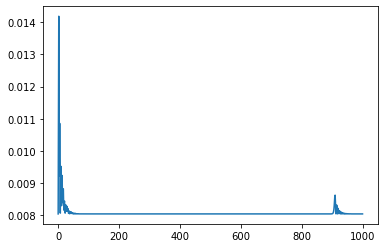

In [25]:
import matplotlib.pyplot as plt
# Combining procedures in a training lopp

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        y_hat = model(x)

        loss = loss_fn(y, y_hat)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

train_step = make_train_step(model, loss_fn, optimizer)
loss_ls = []

for epoch in range(1000):
    loss = train_step(x_train_tensor, y_train_tensor)
    loss_ls.append(loss)

print(model.state_dict())
plt.plot(loss_ls)

## PyTorch Dataset class
### To use mini-batch conveniently, we use DataLoader(), and we wraps data into a class to do so. Loading a batch of data to device also saves RAM.

In [26]:
# You can think of it as a kind of a Python list of tuples, 
# each tuple corresponding to one point (features, label).

from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len__(self):
        return len(self.x)
    
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()      

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))
(tensor([0.7713]), tensor([2.4745]))


In [27]:
from torch.utils.data import DataLoader

train_step = make_train_step(model, loss_fn, optimizer)
loss_ls = []

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

for epoch in range(1000):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        loss_ls.append(loss)

print(model.state_dict())

OrderedDict([('a', tensor([1.0363])), ('b', tensor([1.9746]))])


In [28]:
from torch.utils.data.dataset import random_split

np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

## Evaluation

In [29]:
# Compute validation loss while trainning

train_step = make_train_step(model, loss_fn, optimizer)
loss_ls = []
loss_val_ls = []

for epoch in range(100):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        loss_ls.append(loss)
    
    # NOTE: it is a good practice to wrap the validation inner loop with this context 
    # manager to disable any gradient calculation that you may inadvertently trigger 
    with torch.no_grad():
        for x_batch_val, y_batch_val in val_loader:
            x_batch_val = x_batch_val.to(device)
            y_batch_val = y_batch_val.to(device)
            
            # NOTE: change the model from train to evaluation mode
            model.eval()
            y_hat = model(x_batch_val)
            loss_val = loss_fn(y_batch_val, y_hat)
            loss_val_ls.append(loss_val.item())

print(model.state_dict())
print(np.mean(loss_ls))
print(np.mean(loss_val_ls))

OrderedDict([('a', tensor([1.0192])), ('b', tensor([1.9499]))])
0.009362733662128449
0.005277187158353627


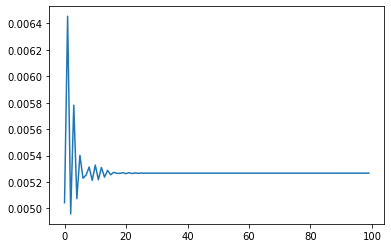

In [30]:
plt.plot(loss_val_ls)

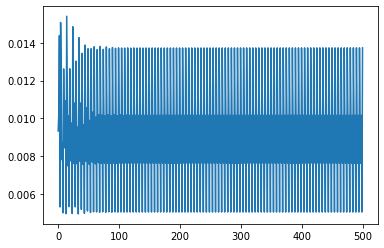

In [31]:
plt.plot(loss_ls)